# Recommender Systems

In an era of overwhelming choices, recommender systems serve as a crucial tool for matching users with relevant products. The fundamental challenge lies in bridging the gap between two entities that are often semantically different—users and products—by identifying meaningful patterns and relationships. A product can be anything that a user might interact with or consume, such as a movie in a streaming service, a book in an online store, or even a job listing in a recruitment platform. The goal of a recommender system is to predict and suggest the most suitable products for each user, improving both user experience and engagement.

To achieve this, recommender systems rely on two major approaches: content-based filtering and collaborative filtering. Content-based filtering uses known attributes of users and products to make recommendations, whereas collaborative filtering learns implicit patterns from past user interactions without requiring predefined features. While content-based filtering aligns well with human intuition—since users and products have explicit characteristics—collaborative filtering captures hidden relationships that may not be immediately obvious.

In both approaches, user ratings or interactions serve as labels that guide the learning process, similar to supervised learning. However, unlike typical supervised tasks, the key challenge in recommender systems is that most labels are missing—users only interact with a small fraction of the available products. While missing features are common in machine learning, having missing labels to this extent is less likely, requiring techniques to infer preferences from sparse data.

## Dataset

The dataset that will be used in this notebook to demonstrate the recommender systems is the MovieLens dataset. The dataset contains rating from 1682 movies rated by 943 users. Since streaming platforms like Netflix is one of the most popular applications of the recommendation systems, this is an appropriate kind of data to make this demonstration.

In [1]:
import pandas as pd
import zipfile
import urllib.request

# URL of the dataset
url = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"

# Download the zip file
urllib.request.urlretrieve(url, "ml-100k.zip")

# Extract the contents
with zipfile.ZipFile("ml-100k.zip", "r") as zip_ref:
    zip_ref.extractall("ml-100k")

In [2]:
# Load the ratings file
ratings = pd.read_csv("ml-100k/ml-100k/u.data", sep="\t", names=["user_id", "item_id", "rating", "timestamp"])

# Load the movie titles
movies = pd.read_csv("ml-100k/ml-100k/u.item", sep="|", encoding="latin-1", names=["item_id", "title"], usecols=[0, 1])

# Merge with ratings
ratings = ratings.merge(movies, on="item_id")

# Display ratings with movie titles
ratings.head()

,user_id,item_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


The main dataset consists of the above columns where each user has a unique *user_id* and each movie/media has a unique *item_id* associated. The ratings will be the labels that will be used to train our models. Note that more features can be added using other files in the dataset which will be done in the content-based filtering part. The merging of this additional data will not be done here for simplicity and also keep in mind that they are not relevant for the collaborative filtering part so anyone interested in collaborative filtering can directly skip to that part.

Let's convert the above table into a matrix form where rows will correspond to movies and columns to different users.

In [3]:
# Create a pivot table with movies as rows, users as columns, and ratings as values
user_item_matrix = ratings.pivot_table(index=["title", "item_id"], columns="user_id", values="rating")
user_item_matrix.head()

,user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
title,item_id,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),1300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-900 (1994),1353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101 Dalmatians (1996),225,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,2.0,4.0,NaN,NaN,NaN,NaN,NaN
12 Angry Men (1957),178,5.0,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187 (1997),330,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The new matrix shows an important issue in the recommender system data that the data is sparse. Here sparsity does not refer to having a 0 value but instead having no value at all because that user did not watch or rate that movie at all which is generally the case. Thus, although it may seem like we have $1682 \times 943$ samples at the beginning, only a really small portion of these is available to us. The training algorithms are adjusted to accustomed for the absence of those labels, as well.

## Content-based filtering

In content-based filtering, the goal is to recommend products to users based on their inherent features. We represent users and products as vectors, where each user $j$ has a feature vector $\mathbf{x}_j^\text{u}$, and each product $i$ has a feature vector $\mathbf{x}_i^\text{p}$. The fundamental idea is to find the best match between these two vectors by measuring their similarity.

A common metric for similarity is the **dot product**, which provides a measure of alignment between two vectors. Often, this value is scaled to lie within a specific range, such as $(0,1)$ or $(-1,1)$, where a higher absolute value indicates stronger similarity or relevance in some way. However, this introduces a fundamental challenge: for the dot product to be meaningful, the two vectors must not only have the same dimensionality but also correspond to the same semantic space.

In a typical user-product setting, this is rarely the case. Users have features like age, gender, and marital status, while products may have features such as release date, color, and size. These features do not naturally align, making direct comparison through dot products meaningless. To overcome this, we need a transformation that maps both user and product vectors into a common space, ensuring that each dimension corresponds to the same type of semantic meaning—though the level of abstraction may vary. To achieve this, we define transformed feature vectors $\tilde{\mathbf{x}}^\text{u}_{j}$ and $\tilde{\mathbf{x}}^\text{p}_{i}$, which project users and products into a shared latent space where meaningful similarity computations can be performed.

In order to train the content-based recommender system, we use a supervised learning approach where the given user ratings serve as ground truth labels. We define $y_{ij}$ as the actual rating provided by user $j$ for product $i$. Our goal is to minimize the squared error between these ratings and the predicted ratings, which are computed as the dot product of the transformed feature vectors, $\tilde{\mathbf{x}}^\text{u}_{j}$ and $\tilde{\mathbf{x}}^\text{p}_{i}$.

Since most ratings are missing, our loss function should only consider pairs $(i,j)$ where $y_{ij}$ is defined. Thus, the objective function is:

$$
J \left( \tilde{\mathbf{x}}^\text{u}_{j}, \tilde{\mathbf{x}}^\text{p}_{i} \right) = \sum_{(i,j) \in \mathcal{D}} \left( y_{ij} - \tilde{\mathbf{x}}^\text{u}_{j} \cdot \tilde{\mathbf{x}}^\text{p}_{i} \right)^2
$$

where $\mathcal{D}$ represents the set of all pairs $(i,j)$ for which a valid rating $y_{ij}$ is available. This ensures that the loss computation only includes observed ratings and avoids undefined values.

While one could attempt to design the transformed feature vectors $\tilde{\mathbf{x}}^\text{u}_{j}$ and $\tilde{\mathbf{x}}^\text{p}_{i}$ manually, this is not a trivial task. Handcrafting such features requires extensive domain expertise and a level of abstract reasoning that is often impractical. Even with deep knowledge of the domain, defining feature transformations that effectively map users and products into a shared space is highly challenging.

To overcome this, we can leverage a **deep learning-based approach**, where the feature transformations are not explicitly designed but instead learned automatically. In modern recommender systems, deep learning models are commonly used for this purpose. Specifically, we introduce two neural networks: a **user network** and a **product network**. These networks take raw user and product features as input and output transformed vectors $\tilde{\mathbf{x}}^\text{u}_{j}$ and $\tilde{\mathbf{x}}^\text{p}_{i}$ of identical dimensionality, ensuring that each dimension captures semantically similar information for both users and products.

With this learned representation, the dot product $\tilde{\mathbf{x}}^\text{u}_j \cdot \tilde{\mathbf{x}}^\text{p}_i$ serves as the predicted rating or a score proportional to the user's preference for the given product. By training the networks to minimize the squared error loss, they learn to produce meaningful feature embeddings that improve recommendation accuracy.


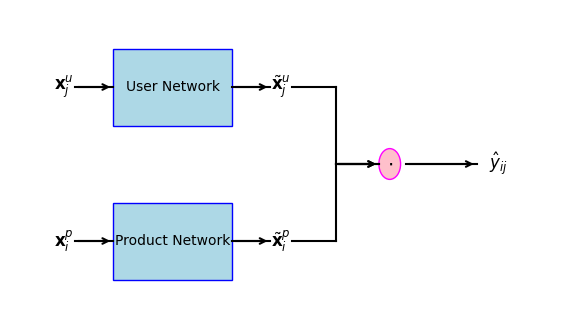

In [58]:
import matplotlib.pyplot as plt

# Create figure and axis
fig, ax = plt.subplots(figsize=(7, 4))

# Define positions
x_u_j_pos = (0, 2)  # Original user feature
user_net_pos = (2, 2)  # User network
x_u_j_tilde_pos = (4, 2)  # Transformed user feature

x_p_i_pos = (0, 0)  # Original product feature
product_net_pos = (2, 0)  # Product network
x_p_i_tilde_pos = (4, 0)  # Transformed product feature

dot_product_pos = (6, 1)  # Dot product
prediction_pos = (8, 1)  # Prediction

# Draw network boxes
ax.add_patch(plt.Rectangle((user_net_pos[0]-1.1, user_net_pos[1]-0.5), 2.2, 1, edgecolor='blue', facecolor='lightblue'))
ax.add_patch(plt.Rectangle((product_net_pos[0]-1.1, product_net_pos[1]-0.5), 2.2, 1, edgecolor='blue', facecolor='lightblue'))
ax.text(user_net_pos[0], user_net_pos[1], "User Network", ha='center', va='center', fontsize=10, color='black')
ax.text(product_net_pos[0], product_net_pos[1], "Product Network", ha='center', va='center', fontsize=10, color='black')

# Draw feature labels before networks
ax.text(x_u_j_pos[0], x_u_j_pos[1], r"$\mathbf{x}^{u}_{j}$", ha='center', va='center', fontsize=12, color='black')
ax.text(x_p_i_pos[0], x_p_i_pos[1], r"$\mathbf{x}^{p}_{i}$", ha='center', va='center', fontsize=12, color='black')

# Draw feature labels after networks (tilde versions)
ax.text(x_u_j_tilde_pos[0], x_u_j_tilde_pos[1], r"$\tilde{\mathbf{x}}^{u}_{j}$", ha='center', va='center', fontsize=12, color='black')
ax.text(x_p_i_tilde_pos[0], x_p_i_tilde_pos[1], r"$\tilde{\mathbf{x}}^{p}_{i}$", ha='center', va='center', fontsize=12, color='black')

# Draw dot product circle
ax.add_patch(plt.Circle(dot_product_pos, 0.2, edgecolor='magenta', facecolor='pink'))
ax.text(dot_product_pos[0], dot_product_pos[1], r"$\cdot$", ha='center', va='center', fontsize=14, color='black')

# Draw prediction box
ax.text(prediction_pos[0], prediction_pos[1], r"$\hat{y}_{ij}$", ha='center', va='center', fontsize=12, color='black')

# Draw arrows with rectangular paths
def draw_rectangular_arrow(start, end):
    """Draws an arrow with a rectangular path."""
    mid_x = (start[0] + end[0]) / 2
    if start[1] == end[1]:  # Horizontal movement
        ax.plot([start[0], end[0]], [start[1], start[1]], 'k-', lw=1.5)
        ax.annotate("", xy=end, xytext=start, arrowprops=dict(arrowstyle="->", color="black", lw=1.5))
    else:  # Rectangular movement
        ax.plot([start[0], mid_x], [start[1], start[1]], 'k-', lw=1.5)  # Horizontal
        ax.plot([mid_x, mid_x], [start[1], end[1]], 'k-', lw=1.5)  # Vertical
        ax.plot([mid_x, end[0]], [end[1], end[1]], 'k-', lw=1.5)  # Horizontal
        ax.annotate("", xy=end, xytext=(mid_x, end[1]), arrowprops=dict(arrowstyle="->", color="black", lw=1.5))

# Connect elements with rectangular arrows
draw_rectangular_arrow((0.2,2), (0.9,2))
draw_rectangular_arrow((3.1,2), (3.8,2))

draw_rectangular_arrow((0.2, 0), (0.9, 0))
draw_rectangular_arrow((3.1, 0), (3.8, 0))

draw_rectangular_arrow((4.2, 2), (5.8, 1))
draw_rectangular_arrow((4.2, 0), (5.8, 1))

draw_rectangular_arrow((6.3, 1), (7.6, 1))

# Adjust plot settings
ax.set_xlim(-1, 9)
ax.set_ylim(-1, 3)
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

# Show plot
plt.show()

The block diagram to be used in similarity calculation is given above. Note that training will also be done in this configuration, which means there are no separate trainings for user and product networks. Even during inference time, although they can be used individually to generate the vectors  $\tilde{\mathbf{x}}^\text{u}_j$ and $\tilde{\mathbf{x}}^\text{p}_i$, these are not beneficial alone so it is practically not possible as well.

### Recommendation

Everything so far seems neat and smooth but how the recommendation is done is the actual point here. The similarity of *things* in content-based algorithm is decided by the final score of 2 vectors $\tilde{\mathbf{x}}$ , either belonging to a product or a user, put into the dot product operation. The product vectors  $\tilde{\mathbf{x}}^\text{p}$ can be computed instantly once a product is available. Moreover, the dot products between different product vector pairs can also be computed offline and stored which is critical to make fast recommendations once a suitable product has been matched with a user. Then, when a new user is subscribed to a service, the user feature vector $\tilde{\mathbf{x}}^\text{u}$ must be calculated only once.

Having the similarity values of product pairs is critical since this means that once a suitable product for a user is found, many more similar things can be recommended almost instantly. In order to make this process efficient, some clustering on the product vectors can be done beforehand and once a user is signed in, instead of calculating the dot product of $\tilde{\mathbf{x}}^\text{u}$ with every available product vector $\tilde{\mathbf{x}}^\text{p}$, this can only be done for the cluster center vectors. If a close match with one of them is found for the user, the other items in that cluster is also most probably a good choice either.

### Implementation

In [4]:
import torch

# ADD PRODUCT FEATURES (products are movies in this case)

# Product metadata is available in u.item, so let's extract it:

# Load product metadata (genres are in the last columns)
product_metadata = pd.read_csv("ml-100k/ml-100k/u.item", sep="|", encoding="latin-1", header=None)
product_metadata = pd.concat([product_metadata.iloc[:, 0:3], product_metadata.iloc[:, 5:24]], axis=1)  # Keep only relevant columns

# Rename columns (MovieLens 100K format)
product_metadata.columns = ["item_id", "title", "release_date"] + [f"genre_{i}" for i in range(19)]

# Merge metadata with ratings dataset
products_with_metadata = ratings.merge(product_metadata, on="item_id")

# Genres are stored as one-hot encoded columns. We can use them directly as feature vectors:

# Extract only genre columns as features
product_features = product_metadata.iloc[:, 3:].values  # 19 genres as one-hot vectors
product_features = torch.tensor(product_features, dtype=torch.float32)

print("Product Feature Shape:", product_features.shape)  # Should be (num_products, 19)



# ADD USER FEATURES

# MovieLens 100K includes a user metadata file (u.user)

# Load user metadata
user_metadata = pd.read_csv("ml-100k/ml-100k/u.user", sep="|", encoding="latin-1", header=None)

# Rename columns
user_metadata.columns = ["user_id", "age", "gender", "occupation", "zip_code"]

# Drop ZIP code since it's not useful for recommendations
user_metadata = user_metadata.drop(columns=["zip_code"])

# Convert the categorical features of gender and occupation to one hot vectors

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Encode Gender (0 = Female, 1 = Male)
user_metadata["gender"] = LabelEncoder().fit_transform(user_metadata["gender"])

# One-Hot Encode Occupation
occupation_onehot = pd.get_dummies(user_metadata["occupation"], dtype=int)
user_metadata = pd.concat([user_metadata.drop(columns=["occupation"]), occupation_onehot], axis=1)
user_features = torch.tensor(user_metadata.iloc[:, 1:].values, dtype=torch.float32)  # Drop user_id column

print("User Features Shape:", user_features.shape)  # (num_users, feature_dim)

Product Feature Shape: torch.Size([1682, 19])
User Features Shape: torch.Size([943, 23])


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm import tqdm

# Set random seed for reproducibility
def set_random_seed(seed=0):
    # random.seed(seed)  # Python random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU (if available)
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False  # Disable optimization that can introduce randomness

# Call the function to set the seed
set_random_seed(0)

# Define Content-Based Filtering Model
class ContentBasedFiltering(nn.Module):
    def __init__(self, num_user_features, num_movie_features, embedding_dim):
        super().__init__()
        # User MLP to learn fixed-size embedding
        self.user_mlp = nn.Sequential(
            nn.Linear(num_user_features, 64),
            nn.ReLU(),
            nn.Linear(64, embedding_dim)  # Output fixed-size embedding v_u
        )

        # Product MLP to learn fixed-size embedding
        self.product_mlp = nn.Sequential(
            nn.Linear(num_movie_features, 64),
            nn.ReLU(),
            nn.Linear(64, embedding_dim)  # Output fixed-size embedding v_m
        )

    def forward(self, user_features, user_idx, product_features, product_idx):
        # Extract user and movie feature vectors
        user_vec = self.user_mlp(user_features[user_idx])
        product_vec = self.product_mlp(product_features[product_idx])

        # Compute similarity (dot product)
        rating_pred = (user_vec * product_vec).sum(dim=1)  # Element-wise product then sum
        return rating_pred

# Sample dimensions (these would be based on your dataset)
num_products, num_users = user_item_matrix.shape
embedding_dim = 10  # Final fixed-size embedding for users & products
alpha = 0.01  # Learning rate
epochs = 1000  # Training iterations

# Convert features & ratings to PyTorch tensors
ratings_tensor = torch.tensor(user_item_matrix.values, dtype=torch.float32)

# Initialize model and optimizer
num_user_features = user_features.shape[1]  # Hypothetical user feature size (e.g., age, genre preference)
num_product_features = product_features.shape[1]  # Hypothetical product feature size (e.g., genre embeddings, description vectors)
model = ContentBasedFiltering(num_user_features, num_product_features, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=alpha)
criterion = nn.MSELoss()  # Mean Squared Error loss

# Create index pairs for training (only for known ratings)
product_idxs, user_idxs  = torch.where(~torch.isnan(ratings_tensor))  # Get valid (user, movie) pairs
ratings_vals = ratings_tensor[product_idxs, user_idxs].float()  # Actual ratings

# Training Loop
for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()

    predictions = model(user_features, user_idxs, product_features, product_idxs)  # Predicted ratings
    loss = criterion(predictions, ratings_vals)  # Compute loss

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# Extract learned embeddings
learned_user_embeddings = model.user_mlp(user_features).detach().numpy()
learned_product_embeddings = model.product_mlp(product_features).detach().numpy()

  0%|          | 1/1000 [00:00<05:43,  2.91it/s]

Epoch 0: Loss = 18.3658


 10%|█         | 102/1000 [00:16<02:23,  6.24it/s]

Epoch 100: Loss = 1.2545


 20%|██        | 202/1000 [00:31<01:54,  6.98it/s]

Epoch 200: Loss = 1.2044


 30%|███       | 302/1000 [00:47<02:01,  5.76it/s]

Epoch 300: Loss = 1.1978


 40%|████      | 402/1000 [01:01<01:52,  5.33it/s]

Epoch 400: Loss = 1.1960


 50%|█████     | 502/1000 [01:16<01:29,  5.58it/s]

Epoch 500: Loss = 1.1946


 60%|██████    | 602/1000 [01:30<00:53,  7.44it/s]

Epoch 600: Loss = 1.1947


 70%|███████   | 702/1000 [01:47<00:47,  6.22it/s]

Epoch 700: Loss = 1.1927


 80%|████████  | 802/1000 [02:03<00:31,  6.36it/s]

Epoch 800: Loss = 1.1926


 90%|█████████ | 901/1000 [02:18<00:17,  5.72it/s]

Epoch 900: Loss = 1.1912


100%|██████████| 1000/1000 [02:33<00:00,  6.50it/s]


## Collaborative Filtering

In the previous case of content-based filtering, we had vector representations of fixed and equal length for the users and products; and any kind of similarity or relevance was decided based on the numerical closeness of these vectors. While content-based filtering relies on predefined user and product features, collaborative filtering offers an alternative approach: it learns directly from user-product interaction data, without requiring explicit feature definitions. This makes it particularly useful when metadata about users or products is unavailable or insufficient.

Let's define a linear estimator for ratings as;

$$
\hat{y}_{ij} = \mathbf{w}_{j}^T \mathbf{x}_{i} + b_{j}
$$

where $\mathbf{w}_{j}^T$ and  $b_{j}$ are user related parameters and $\mathbf{x}_{i}$ is a product based feature vector. Note that the superscripts $\text{u}$ and $\text{p}$ are dropped here because there is a clearer separation of which parameter/variable belongs to what and indices are sufficient for the purposes of this title. Now given the feature vectors $\mathbf{x}_{i}$ and corresponding ground truth ratings $y_{ij}$, the above problem can be optimized by

$$
\min_{\substack{\mathbf{w}_{1}, \mathbf{w}_{2}, \dots , \mathbf{w}_{n_\text{u}} \\ b_{1}, b_{2}, \dots , b_{n_\text{u}}}} \sum_{j=1}^{n_\text{u}}\sum_{(i,j) \in \mathcal{D}} \left( y_{ij} - \left( \mathbf{w}_{j}^T \mathbf{x}_{i} + b_{j} \right) \right)^2
$$

This is basically a modified linear regression cost function that is updated for multiple $\mathbf{w}_{j}$ and  $b_{j}$ candidates and also $\mathcal{D}$ under the summation showing only the cases that a valid rating is obtained. It is important to know the nuances here that make it differ from a classic linear regression problem but at the end of the day, this is still linear regression that aims to find optimized weights and biases. Let's go to a more interesting case than that now.

This time let's assume the optimal weights and $\mathbf{w}_{j}$ and biases $b_{j}$ are given to us and instead we are trying to find the feature vectors $\mathbf{x}_{i}$ for these optimal coefficients. Without questioning much, just assume hypothethically this is possible. Then, we need to have optimization problem;

$$
\min_{\mathbf{x}_{1}, \mathbf{x}_{2}, \dots , \mathbf{x}_{n_\text{p}}} \sum_{i=1}^{n_\text{p}}\sum_{(i,j) \in \mathcal{D}} \left( y_{ij} - \left( \mathbf{w}_{j}^T \mathbf{x}_{i} + b_{j} \right) \right)^2
$$

This appears like more or less the same problem but the important difference is that the optimization parameters are the vectors themselves. The question at this moment is that how can we know the optimal $\mathbf{w}_{j}$ and $b_{j}$ to begin with if they had their own optimization problem.

It turns out that if we make a total random initialization of paramters $\mathbf{w}_{j}$ and $b_{j}$; and the features $\mathbf{x}_{i}$ and then apply the above problems one after the other, on the long run the trend will be in a way that the parameters will be optimized for the vectors and the vectors will be adapted to minimize the overall error, as well. Hence, both will be optimized in a way that will reinforce themselves and a global optimum will be approached. These two can be merged into a single optimization problem as;

$$
\min_{\substack{\mathbf{w}_{1}, \mathbf{w}_{2}, \dots , \mathbf{w}_{n_\text{u}} \\ b_{1}, b_{2}, \dots , b_{n_\text{u}} \\ \mathbf{x}_{1}, \mathbf{x}_{2}, \dots , \mathbf{x}_{n_\text{p}}}} \sum_{i=1}^{n_\text{p}} \sum_{j=1}^{n_\text{u}} \sum_{(i,j) \in \mathcal{D}} \left( y_{ij} - \left( \mathbf{w}_{j}^T \mathbf{x}_{i} + b_{j} \right) \right)^2
$$

This can be seen as a simple problem and indeed it is but what is so remarkable about it is that this is one of the rare cases that a learning mechanism does not only find optimal coefficients for a task but it also generates the optimal features to achieve it without even starting from less useful features and only a random initialization is sufficient. The variants of the algorithm can be done to make the initialization of $\mathbf{x}_{i}$'s from known features of the products but important point is that it is not obligatory and an optimization is possible starting from scratch.

### Cold Start Problem

One of the drawbacks of the collaborative filtering is that it does not allow for a simple assesment of a previously unknown user defined by the tuple $(\mathbf{w}_{j}, b_{j})$ and unknown product defined by feature vector $\mathbf{x}_{i}$. Both of these things have to go through some sort of training process to be meaningful. This was not the case in the content-based filtering because after doing the initial learning with a training set, we have well defined blocks of user and product networks which can be used to convert any new input into useful representations. This is called the **cold-start problem** and is an obstacle to instant handling of a newly joined user to a service or a newly added product in that service.

### Recommendation

As in the case of content-based filtering the similar products can be defined based on the closeness of the feature vectors $\mathbf{x}_{i}$. In a similar manner, they can also be grouped into clusters and once a user is associated with the cluster center vector or any particular product within that cluster, other items in the cluster will also be nice recommendation choices, as well.

Unlike the content-based filtering, there is no direct notion of a user vector in collaborative filtering. The closest thing is the linear operation between the tuple $(\mathbf{w}_{j}, b_{j})$ and the product vector $\mathbf{x}_{i}$ can be considered as a dot product, as well. The major difference is that those $(\mathbf{w}_{j}, b_{j})$ tuples for a user are directly generated by the ratings of that user and are not available until a few ratings are done, which was the reason for the cold-start problem discussed. Thus, the first recommendations to that user can be done either by totally randomly, by using other features of the user like demographic information, using a mean normalization technique so that the user will be assigned a tuple $(\mathbf{w}_{j}, b_{j})$ such that he/she made ratings as the average of actual ratings of the other users.

### Implementation

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm import tqdm

# Set random seed for reproducibility
def set_random_seed(seed=0):
    # random.seed(seed)  # Python random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU (if available)
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False  # Disable optimization that can introduce randomness

# Call the function to set the seed
set_random_seed(0)

# Convert ratings DataFrame to NumPy and handle NaNs
ratings = user_item_matrix.values
mask = ~np.isnan(ratings)  # Boolean mask for known ratings
ratings = np.nan_to_num(ratings)  # Convert NaNs to 0 for PyTorch

# # Parameters
# num_users = user_item_matrix.shape[1]  # Number of users
# num_movies = user_item_matrix.shape[0]  # Number of movies
num_products, num_users = user_item_matrix.shape
num_features = 10  # Number of latent factors
alpha = 0.1  # Learning rate
epochs = 1000  # Number of training iterations

# Convert to PyTorch tensors
ratings_tensor = torch.tensor(ratings, dtype=torch.float32)
mask_tensor = torch.tensor(mask, dtype=torch.float32)

# Define Collaborative Filtering Model
class CollaborativeFiltering(nn.Module):
    def __init__(self, num_users, num_products, num_features):
        super().__init__()
        self.user_features = nn.Parameter(torch.rand(num_users, num_features))  # User feature matrix (w)
        self.product_features = nn.Parameter(torch.rand(num_products, num_features))  # Product feature matrix (x)
        self.user_bias = nn.Parameter(torch.rand(num_users))  # User biases (b)

    def forward(self):
        return torch.matmul(self.product_features, self.user_features.T) + self.user_bias  # Predicted ratings

# Initialize model and optimizer
model = CollaborativeFiltering(num_users, num_products, num_features)
optimizer = optim.Adam(model.parameters(), lr=alpha)

# Loss function (MSE but applied only to known ratings)
def masked_loss(pred, true, mask):
    return torch.sum(((pred - true) * mask) ** 2) / torch.sum(mask)

# Training Loop
for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    predictions = model()
    loss = masked_loss(predictions, ratings_tensor, mask_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# Extract learned features
learned_user_features = model.user_features.detach().numpy()
learned_product_features = model.product_features.detach().numpy()

  0%|          | 4/1000 [00:00<00:58, 17.15it/s]

Epoch 0: Loss = 2.1201


 11%|█         | 107/1000 [00:03<00:26, 33.35it/s]

Epoch 100: Loss = 0.4926


 21%|██        | 207/1000 [00:06<00:24, 32.25it/s]

Epoch 200: Loss = 0.4618


 30%|███       | 305/1000 [00:10<00:21, 31.95it/s]

Epoch 300: Loss = 0.4527


 40%|████      | 405/1000 [00:13<00:18, 31.79it/s]

Epoch 400: Loss = 0.4487


 50%|█████     | 505/1000 [00:16<00:15, 32.51it/s]

Epoch 500: Loss = 0.4466


 60%|██████    | 603/1000 [00:20<00:17, 22.69it/s]

Epoch 600: Loss = 0.4452


 70%|███████   | 704/1000 [00:23<00:09, 31.06it/s]

Epoch 700: Loss = 0.4444


 80%|████████  | 804/1000 [00:26<00:06, 32.42it/s]

Epoch 800: Loss = 0.4436


 90%|█████████ | 904/1000 [00:29<00:03, 32.00it/s]

Epoch 900: Loss = 0.4430


100%|██████████| 1000/1000 [00:33<00:00, 30.04it/s]
